In [ ]:
# !pip install geemap

# AWD monitoring using Sentinel 1

In [1]:
import ee
import geemap
import datetime

import pandas as pd
import numpy as np
import plotly.express as px

In [2]:
ee.Initialize()

In [3]:
# geemap.update_package()

## 1. Spatial plot of Sentinel 1 data for the selected date range

In [4]:
# Area of interest. Defined by a polygon

# # Define the polygon geometry
# geometry = ee.Geometry.Polygon([[90.87974051393725, 24.027515849512838],
#                                  [90.88031987108447, 24.027515849512838],
#                                  [90.88031987108447, 24.027927414524406],
#                                  [90.87974051393725, 24.027927414524406],
#                                  [90.87974051393725, 24.027515849512838]])


# AWD in day 3 site. apply water every 6 days
geometry = ee.Geometry.Polygon([
  [89.00239529326589, 23.363047351642273],
  [89.00177838519247, 23.363022728677635],
  [89.001874944717, 23.362623836013544],
  [89.00238456442983, 23.362658308266433],
  [89.00239529326589, 23.363047351642273]
]);

# # CF in day 3 site. apply water every 2 days
# geometry = ee.Geometry.Polygon([
#   [89.00103809550436, 23.362348057667866],
#   [89.0011185617748, 23.362032881713567],
#   [89.00181057170064, 23.362141223532323],
#   [89.00177302077444, 23.362451474614677],
#   [89.00115611270101, 23.36237268075776],
#   [89.00103809550436, 23.362348057667866]
# ]);

In [5]:
# Define start and end dates
startDate = '2021-01-01'
endDate = '2022-03-30'

In [6]:
m = geemap.Map()

imgVV = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .filter(ee.Filter.eq('instrumentMode', 'IW')) \
    .select('VV') \
    .map(lambda image: image.updateMask(image.lt(-30.0).Not().mask()))

desc = imgVV.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))
asc = imgVV.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))

# Define a list of filter dates
filter_dates = [('2023-01-01', '2023-01-30'),
                 ('2023-02-01', '2023-02-28'),
                 ('2023-03-01', '2023-03-03')]

# Compute the mean image for each filter date
mean_images = [imgVV.filterDate(start_date, end_date).mean() for start_date, end_date in filter_dates]

# Get the middle date of each filter date range
middle_dates = [(datetime.datetime.strptime(start_date, '%Y-%m-%d') + datetime.timedelta(days=14)).strftime('%Y-%m-%d') for start_date, end_date in filter_dates]

# Add each mean image as a layer to the map, with the middle date as the layer label
for mean_image, middle_date in zip(mean_images, middle_dates):
    m.addLayer(mean_image, {'min': -25, 'max': 5}, middle_date, True)

f = imgVV.filterBounds(geometry).filterDate(startDate, endDate)

# Put all dates in a list
dates = f.aggregate_array("system:time_start").map(lambda d: ee.Date(d))

# Print a list with dates
# print(dates.getInfo())

In [7]:
m.add_basemap('HYBRID')
m.centerObject(geometry, zoom=16)
m.addLayer(geometry, {'color': 'red'}, 'Polygon')

m

Map(center=[23.362844116577374, 89.00210579267959], controls=(WidgetControl(options=['position', 'transparent_…

### Data availability withing the selected polygon within the selected date range

In [8]:
# Filter the Sentinel-2 Image Collection
sentinel2 = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filterBounds(geometry) \
    .filterDate(startDate, endDate)

# Define the function to get the date, orbit path number, and count non-null pixels for each image
def get_date_orbit_path_and_count_pixels(image):
    # Create a binary mask where 1 indicates non-null pixels and 0 indicates null pixels
    mask = image.select('B4').mask()
    # Count non-null pixels within the polygon
    pixel_count = mask.reduceRegion(reducer=ee.Reducer.count(),
                                     geometry=geometry,
                                     scale=10).get('B4')
    # Get the date and orbit path number of the image
    date = image.date().format('YYYY-MM-dd')
    orbit_path = image.get('SENSING_ORBIT_NUMBER')
    return image.set('pixelCount', pixel_count).set('date', date).set('orbitPath', orbit_path)

# Apply the function to the image collection
sentinel2_with_dates_orbit_paths_and_counts = sentinel2.map(get_date_orbit_path_and_count_pixels)

# Print the result
dates = sentinel2_with_dates_orbit_paths_and_counts.aggregate_array('date').getInfo()
orbit_paths = sentinel2_with_dates_orbit_paths_and_counts.aggregate_array('orbitPath').getInfo()
pixel_counts = sentinel2_with_dates_orbit_paths_and_counts.aggregate_array('pixelCount').getInfo()


In [9]:
# Create a pandas dataframe from the dates, orbit_paths, and pixel_counts
df = pd.DataFrame({'Date': dates, 'Orbit Path': orbit_paths, 'Pixel Count': pixel_counts})

# Display the dataframe in a nice format
print(df)

           Date  Orbit Path  Pixel Count
0    2021-01-04          33           27
1    2021-01-04          33           27
2    2021-01-09          33           27
3    2021-01-09          33           27
4    2021-01-14          33           27
..          ...         ...          ...
173  2022-03-15          33           27
174  2022-03-20          33           27
175  2022-03-20          33           27
176  2022-03-25          33           27
177  2022-03-25          33           27

[178 rows x 3 columns]


In [10]:
# Get the unique values in the list by converting it to a set.
unique_orbit_paths = set(orbit_paths)

# If you need the unique values as a list, convert the set back to a list.
unique_orbit_paths_list = list(unique_orbit_paths)

print(unique_orbit_paths_list)

[33]


### Plot histogram of sentinal 1 backscattering values for given date range inside polygon

In [11]:
# Information of geometry to zoom
centroid = geometry.centroid().getInfo()['coordinates']
center = [centroid[1], centroid[0]]

# Create a map centered on the polygon geometry
Map = geemap.Map(center=center, zoom=16)
Map.add_basemap('HYBRID')
Map.add_ee_layer(geometry, {'color': 'red'}, 'Polygon geometry')

# Filter the Sentinel-1 VV dataset to the geometry and date range
sentinel_1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterBounds(geometry) \
    .filterDate('2021-01-01', '2022-12-31') \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .filter(ee.Filter.eq('instrumentMode', 'IW'))

# Get the median image from the Sentinel-1 VV dataset
median_image = sentinel_1.median()

Map.add_ee_layer(median_image.select('VV'), {'min': -25, 'max': 5, 'palette': 'gray'}, 'Median Image')

# Display the map
Map

Map(center=[23.362844116577374, 89.00210579267959], controls=(WidgetControl(options=['position', 'transparent_…

In [12]:
# Get the values within the polygon as a feature collection
values = median_image.reduceRegion(
    reducer=ee.Reducer.toList(),
    geometry=geometry,
    scale=10,
    maxPixels=1e10
).get('VV')

# Convert the feature collection to a pandas dataframe
df = pd.DataFrame(values.getInfo(), columns=['VV'])

# Plot a histogram of df.VV with a small interval
plt.hist(df['VV'], bins=15)
plt.xlabel('VV values')
plt.ylabel('Frequency')
plt.title('Histogram of VV values')
plt.show()


NameError: name 'plt' is not defined

### Plot time series of VV

In [476]:
# Define start and end dates
start_date = '2023-01-01'
end_date = '2023-03-30'

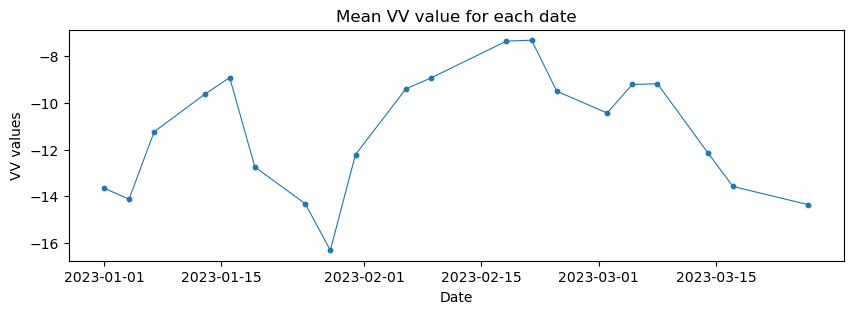

In [477]:
# Filter the Sentinel-1 VV dataset to the geometry and date range
sentinel_1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterBounds(geometry) \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .filter(ee.Filter.eq('instrumentMode', 'IW'))
    
# Get the time series of VV values within the polygon
values = sentinel_1.filterBounds(geometry).getRegion(geometry, 10).getInfo()

# # Convert the time series to a pandas dataframe
df = pd.DataFrame(values[1:], columns=values[0])
df['time'] = pd.to_datetime(df['time'], unit='ms')
df['date'] = df['time'].dt.date
# df = df.set_index('date')
df['VV'] = df['VV'].astype(float)

# Calculate the mean VV value for each date
df_vv_mean = df.groupby('date').mean()

# Plot the mean VV value for each date with a figure dimension of 12 by 4
plt.figure(figsize=(10, 3))
df_vv_mean['VV'].plot(linewidth=0.8)
plt.scatter(df_vv_mean.index, df_vv_mean['VV'], s=10)
plt.xlabel('Date')
plt.ylabel('VV values')
plt.title('Mean VV value for each date')
plt.show()


In [478]:
df.head(3)

,id,longitude,latitude,time,VV,VH,angle,date
0,S1A_IW_GRDH_1SDV_20230101T235628_20230101T2356...,89.001171,23.362081,2023-01-01 23:56:28,-13.584390,-21.090999,43.566517,2023-01-01
1,S1A_IW_GRDH_1SDV_20230104T121246_20230104T1213...,89.001171,23.362081,2023-01-04 12:12:46,-16.622869,-29.138758,42.166882,2023-01-04
2,S1A_IW_GRDH_1SDV_20230107T000435_20230107T0005...,89.001171,23.362081,2023-01-07 00:04:35,-8.728052,-25.263304,30.758656,2023-01-07


### Flood/no-flood determination

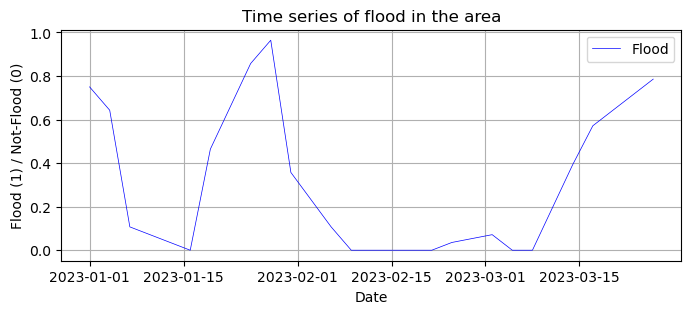

In [479]:
df['flood'] = np.where(df['VV'] < -13, 1, 0)

# Plot the time series of the flood column
plt.figure(figsize=(8, 3))
df.groupby('date').mean()['flood'].plot(linewidth=0.5, color='blue')
plt.xlabel('Date')
plt.ylabel('Flood (1) / Not-Flood (0)')
plt.title('Time series of flood in the area')
plt.grid(True, which='both', axis='both')
plt.legend(['Flood'])
plt.show()


#### Interactive plot

In [480]:
fig = px.line(df.groupby('date').mean(), y='flood', title='Time series of flood in the area')
fig.update_layout(xaxis_title='Date', yaxis_title='Flood (1) / Not-Flood (0)', plot_bgcolor='white', height=400, width=800)
fig.update_yaxes(range=[0, 1], showgrid=True)
fig.show()

### Applying AWD

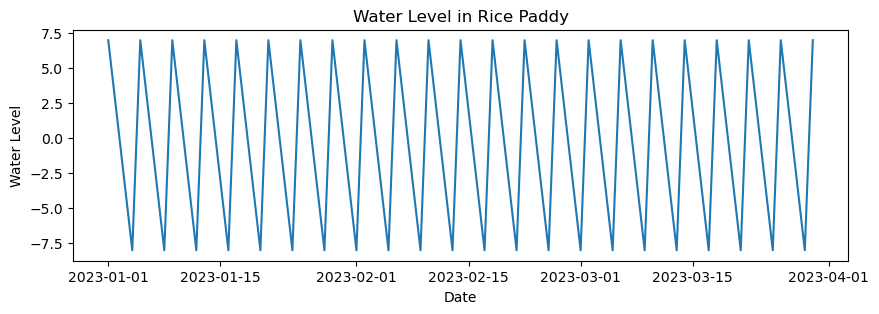

In [481]:
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

infil_rate = (7 +8)/3 # infiltration rate inch/day

# say that water level at -8 inch is the benchmark
water_level = []
for i in range(0, len(date_range), 4):
    flood_lvl = 7 + 8
    interm1 = (7+8) - infil_rate
    interm2 = interm1 - infil_rate
    dry = 0
    
    water_level.append(flood_lvl)
    water_level.append(interm1)
    water_level.append(interm2)
    water_level.append(dry)

water_level = [level - 8 for level in water_level] # getting everything to ground level reference

# Make sure that the length of the water_level list is the same as the length of the date_range list
if len(date_range) < len(water_level):
    water_level = water_level[:len(date_range)]
elif len(date_range) > len(water_level):
    water_level += [water_level[-1]] * (len(date_range) - len(water_level))

water_level = pd.Series(data=water_level, index=date_range)
    

df_awd = pd.DataFrame({'date': date_range, 'water_level': water_level})
df_awd['date'] = pd.to_datetime(df_awd['date'])
df_awd = df_awd.set_index('date')


df_awd = pd.DataFrame({'date': date_range, 'water_level': water_level})

plt.figure(figsize = (10,3))
plt.plot(df_awd['date'], df_awd['water_level'])
plt.xlabel('Date')
plt.ylabel('Water Level')
plt.title('Water Level in Rice Paddy')
plt.show()


### Combined plot of AWD and flooding

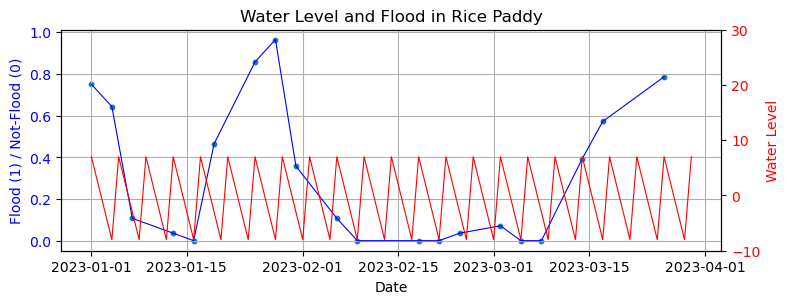

In [482]:
flood = df.groupby('date').mean()['flood']

# Code for the second time series
water_level = df_awd['water_level']

# Plot both time series in one figure
fig, ax1 = plt.subplots(figsize=(8, 3))

color = 'blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Flood (1) / Not-Flood (0)', color=color)
ax1.plot(flood.index, flood, color=color, linewidth=0.8)
ax1.scatter(flood.index, flood, s=10)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, which='both', axis='both')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'red'
ax2.set_ylabel('Water Level', color=color)  # we already handled the x-label with ax1
ax2.plot(water_level.index, water_level, color=color, linewidth=0.8)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([-10, 30])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Water Level and Flood in Rice Paddy')
plt.show()

## AWD model updated based on Sentilel measurements

In [483]:
# Given list of days when water is applied. Assume water application day is given every 4 days
water_application_days = []
for i in range(0, len(date_range), 4):
    water_application_days.append(i)


# Initialize the water level list
water_level = []

# Loop through each day in the date range
for i, date in enumerate(date_range):
    if i in water_application_days:
        flood_lvl = 15
        water_level.append(flood_lvl)
    else:
        water_level.append(water_level[-1] - infil_rate)
        

# Convert the water_level list to a pandas Series with the date range as the index
water_level = pd.Series(data=water_level, index=date_range)

df_awd_mod = pd.DataFrame({'date': date_range, 'water_level': water_level})
df_awd_mod['date'] = pd.to_datetime(df_awd_mod['date'])
df_awd_mod = df_awd_mod.set_index('date')


df_awd_mod = pd.DataFrame({'date': date_range, 'water_level': water_level})

df_awd_mod['water_level'] = df_awd_mod['water_level'] - 8


In [484]:
flood_mod = pd.DataFrame(flood)
flood_mod['date'] = pd.to_datetime(flood_mod.index)
flood_mod.flood = flood_mod.flood* 24 # assuming flood value 1 is equivalent to 12 inch depth
flood_mod = flood_mod.reset_index(drop=True)

In [485]:
df_awd_mod = df_awd_mod.merge(flood_mod, on='date', how='left')
df_awd_mod.tail(2)

,date,water_level,flood
87,2023-03-29,-8.0,NaN
88,2023-03-30,7.0,NaN


In [486]:
for i in range(len(df_awd_mod)):
    if pd.notnull(df_awd_mod.loc[i, 'flood']):
        diff = df_awd_mod.loc[i, 'flood'] - df_awd_mod.loc[i, 'water_level']
        for j in range(i+1, len(df_awd_mod)):
            if pd.notnull(df_awd_mod.loc[j, 'flood']):
                break
            else:
                df_awd_mod.loc[j, 'water_level'] += diff

df_awd_mod['water_level'] = np.where(df_awd_mod['flood'].notnull(), df_awd_mod['flood'], df_awd_mod['water_level'])
df_awd_mod = df_awd_mod.drop(['flood'], axis=1)

In [487]:
df_awd_mod.tail(2)

,date,water_level
87,2023-03-29,3.857143
88,2023-03-30,18.857143


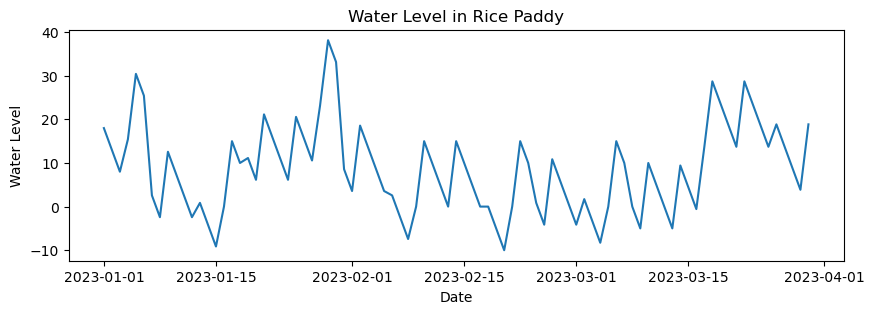

In [488]:
plt.figure(figsize = (10,3))
plt.plot(df_awd_mod['date'], df_awd_mod['water_level'])
plt.xlabel('Date')
plt.ylabel('Water Level')
plt.title('Water Level in Rice Paddy')
plt.show()

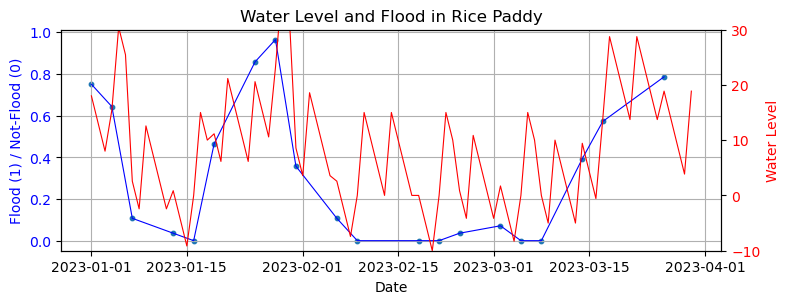

In [489]:
# Plot both time series in one figure
fig, ax1 = plt.subplots(figsize=(8, 3))

color = 'blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Flood (1) / Not-Flood (0)', color=color)
ax1.plot(flood.index, flood, color=color, linewidth=0.8)
ax1.scatter(flood.index, flood, s=10)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, which='both', axis='both')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'red'
ax2.set_ylabel('Water Level', color=color)  # we already handled the x-label with ax1
ax2.plot(df_awd_mod.date, df_awd_mod.water_level, color=color, linewidth=0.8)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([-10, 30])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Water Level and Flood in Rice Paddy')
plt.show()

### Note:

Data needed:
- Water level after irrigation and before irrigation at the site. This is needed to train the AWD model
- Infiltration rate need to be estimated from soil profile or data on infiltration/day


Uncertainty:
- The model has to take into account precipitation and evapotranspiration
    - There is seasonal differences in evapotranspiration
    - If precipitation occurs during AWD, it is important to know if precipitation happened and would be great to train the model to update model to take into account the precipitation effect

To estimate soil moisture from Sentinel-1 data, you can use a simple approach called the Change Detection Method. This method calculates the difference in backscatter values between two images taken on different dates. The change in backscatter can be related to changes in soil moisture. 

In [17]:
# Define your area of interest (AOI)
geometry = ee.Geometry.Polygon([
    [89.00239529326589, 23.363047351642273],
    [89.00177838519247, 23.363022728677635],
    [89.001874944717, 23.362623836013544],
    [89.00238456442983, 23.362658308266433],
    [89.00239529326589, 23.363047351642273]
])

# Information of geometry to zoom
centroid = geometry.centroid().getInfo()['coordinates']
center = [centroid[1], centroid[0]]

# Create a map centered on the polygon geometry
Map = geemap.Map(center=center, zoom=16)
Map.add_basemap('HYBRID')
Map.add_ee_layer(geometry, {'color': 'red'}, 'Polygon geometry')

# Define the date ranges to compare
date1_start = '2022-01-01'
date1_end = '2022-01-15'
date2_start = '2022-01-16'
date2_end = '2022-01-31'

# Filter the Sentinel-1 VV dataset to the geometry and date range
sentinel_1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterBounds(geometry) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .filter(ee.Filter.eq('instrumentMode', 'IW'))

# Get the median image for both date ranges
image1 = sentinel_1.filterDate(date1_start, date1_end).median()
image2 = sentinel_1.filterDate(date2_start, date2_end).median()

# Calculate the change in backscatter values
change = image2.select('VV').subtract(image1.select('VV'))

# Display the change in backscatter values
Map.add_ee_layer(change, {'min': -5, 'max': 5, 'palette': ['blue', 'white', 'red']}, 'Change in Backscatter')

# Display the map
Map

Map(center=[23.362844116577374, 89.00210579267959], controls=(WidgetControl(options=['position', 'transparent_…